In [1]:
import numpy as np
from numpy.typing import NDArray
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
from typing import Tuple

In [2]:
# 価格を生成する関数
def create_price(r_min: float, r_max: float, M: int) -> NDArray[np.float_]:
    # r_minとr_maxの間のランダムな0.1刻みの少数をM個生成
    price = np.random.uniform(r_min, r_max, M)
    price = np.round(price, 1)

    return price


# alphaを作成する関数
def alpha_star(M: int) -> NDArray[np.float_]:
    alpha_star = np.random.uniform(M, 3 * M, size=M)
    return alpha_star


# betaを作成する関数
def beta_star(M: int, M_prime: int) -> NDArray[np.float_]:
    beta_star = np.zeros((M, M_prime))

    for m in range(M):
        for m_prime in range(M_prime):
            if m == m_prime:
                beta_star[m, m_prime] = np.random.uniform(-2 * M, -M)
            else:
                beta_star[m, m_prime] = np.random.uniform(0, 1)

    return beta_star


def quantity_function(
    price: NDArray[np.float_],
    alpha: NDArray[np.float_],
    beta: NDArray[np.float_],
    delta: float = 0.1,  # ノイズレベルを指定（例として0.1を使用）
) -> list[float]:
    M = len(price)
    quantity_list = []
    q_m_no_noise = []

    # ステップ1: ノイズなしのq_mを計算
    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]
        quantity = alpha[m] + sum_beta
        q_m_no_noise.append(quantity)

    # E[q_m^2]を計算
    E_q_m_squared = np.mean(np.array(q_m_no_noise) ** 2)

    # ステップ2: ノイズの標準偏差sigmaを計算
    sigma = delta * np.sqrt(E_q_m_squared)

    # ステップ3: ノイズを加えて最終的なq_mを計算
    for m in range(M):
        epsilon = np.random.normal(0, sigma)
        quantity = q_m_no_noise[m] + epsilon
        quantity_list.append(quantity)

    return quantity_list


def sales_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    sales_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        sales_list.append(quantity * price[m])

    return sales_list

In [3]:
def create_date(M, N):
    alpha = alpha_star(M)
    beta = beta_star(M, M)

    price_list = []
    quantity_list = []

    for _ in range(N):
        price = create_price(0.6, 1.0, M)
        quantity = quantity_function(price, alpha, beta)
        price_list.append(price)
        quantity_list.append(quantity)

    X = np.array(price_list)
    Y = np.array(quantity_list)

    return alpha, beta, X, Y

In [4]:
def create_bounds(M):
    lb = np.full(M, 0.6)
    ub = np.full(M, 1.0)

    bounds = []
    for i in range(M):
        bounds.append(lb[i])

    for i in range(M):
        bounds.append(ub[i])

    return lb, ub, bounds

In [5]:
# 目的関数を定義（最大化問題を最小化問題に変換）
def sales_objective_function(prices, alpha, beta, M):
    return -sum(
        prices[m] * (alpha[m] + sum(beta[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )

In [6]:
def sales_optimize(
    M: int,
    alpha: np.ndarray,
    beta: np.ndarray,
) -> Tuple[float, np.ndarray]:
    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 各価格の範囲を設定（0.6から1.0）
    bounds = [(0.6, 1.0) for _ in range(M)]
    # 最適化を実行
    result = minimize(
        sales_objective_function,
        initial_prices,
        args=(alpha, beta, M),
        bounds=bounds,
        method="L-BFGS-B",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices

In [7]:
# 目的関数を定義
def predict_objective_function(
    prices: NDArray[np.float_], intercepts: [float], coefs: [NDArray[np.float_]], M: int
) -> float:
    # 各変数の内容をデバッグ出力
    # print("prices:", prices)
    # print("intercepts:", intercepts)
    # print("coefs:", coefs)
    # print("M:", M)

    return -sum(
        prices[m]
        * (intercepts[m] + sum(coefs[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )

In [8]:
# 予測と最適化を行う関数
def predict_optimize(
    M: int, X: NDArray[np.float_], Y: NDArray[np.float_], bounds: list[float]
) -> tuple[float, NDArray[np.float_]]:
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)
    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 最適化を実行
    result = minimize(
        predict_objective_function,
        initial_prices,
        args=(intercepts, coefs, M),
        bounds=bounds,
        method="L-BFGS-B",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices

In [9]:
# CVを行う関数
def cross_validation(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）
        bounds = [(0.6, 1.0) for _ in range(M)]
        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return np.mean(optimal_sales_list)

In [10]:
# CVを行う関数
def cross_validation_lb(
    lb: list[float],
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    bounds = [(lb[m], 1.0) for m in range(M)]

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return -np.mean(optimal_sales_list)

In [11]:
def esitimate_lb_nelder(lb, M, X, y, K, adaptive=True):
    # adaptive=Trueの場合、optionsにadaptive=Trueを指定
    bounds_nelder = minimize(
        cross_validation_lb,
        lb,
        args=(X, y, M, K),
        method="Nelder-Mead",
        bounds=[(0.6, 1.0) for _ in range(M)],
        options={"adaptive": adaptive},
    )

    bounds_list = []
    for i in range(M):
        bounds_list.append((bounds_nelder.x[i], 1.0))
    return -bounds_nelder.fun, bounds_list

In [12]:
# CVを行う関数
def cross_validation_ub(
    ub: list[float],
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    bounds = [(0.6, ub[m]) for m in range(M)]

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return -np.mean(optimal_sales_list)

In [13]:
def esitimate_ub_nelder(ub, M, X, y, K, adaptive=True):
    # adaptive=Trueの場合、optionsにadaptive=Trueを指定
    bounds_nelder = minimize(
        cross_validation_ub,
        ub,
        args=(X, y, M, K),
        method="Nelder-Mead",
        bounds=[(0.6, 1.0) for _ in range(M)],
        options={"adaptive": adaptive},
    )

    bounds_list = []
    for i in range(M):
        bounds_list.append((0.6, bounds_nelder.x[i]))
    return -bounds_nelder.fun, bounds_list

In [14]:
# CVを行う関数
def cross_validation_bounds_inf(
    bounds: list[float],
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    bounds_list = []

    for i in range(M):
        if bounds[i] > bounds[i + M]:
            return np.inf

        else:
            bounds_list.append((bounds[i], bounds[i + M]))

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds_list,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return -np.mean(optimal_sales_list)

In [15]:
def estimate_bounds_inf_nelder(bounds, M, X, y, K, adaptive=True):
    bounds_nelder = minimize(
        cross_validation_bounds_inf,
        bounds,
        args=(X, y, M, K),
        method="Nelder-Mead",
        bounds=[(0.6, 1.0) for _ in range(2 * M)],
        options={"adaptive": adaptive},
    )

    opt_bounds = []
    for i in range(M):
        opt_bounds.append((bounds_nelder.x[i], bounds_nelder.x[i + M]))

    return -bounds_nelder.fun, opt_bounds

In [16]:
# CVを行う関数
def cross_validation_bounds_zero(
    bounds: list[float],
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    bounds_list = []

    for i in range(M):
        if bounds[i] > bounds[i + M]:
            return 0

        else:
            bounds_list.append((bounds[i], bounds[i + M]))

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds_list,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return -np.mean(optimal_sales_list)

In [17]:
def estimate_bounds_zero_nelder(bounds, M, X, y, K, adaptive=True):
    bounds_nelder = minimize(
        cross_validation_bounds_zero,
        bounds,
        args=(X, y, M, K),
        method="Nelder-Mead",
        bounds=[(0.6, 1.0) for _ in range(2 * M)],
        options={"adaptive": adaptive},
    )

    opt_bounds = []
    for i in range(M):
        opt_bounds.append((bounds_nelder.x[i], bounds_nelder.x[i + M]))

    return -bounds_nelder.fun, opt_bounds

In [18]:
M = 5
N = 500
K = 5
alpha, beta, X, Y = create_date(M, N)

lb, ub, bounds = create_bounds(M)
initial_price = np.full(M, 0.6)

In [19]:
M = 5
N = 500

opt_val_list = []

opt_sales_list = []

salse_opt_list = []

cv_list = []

cv_lb_list = []

cv_ub_list = []

cv_bounds_list = []

cv_bounds_zero_list = []

ub_opt_list = []

lb_opt_list = []

bounds_opt_list = []

bounds_zero_opt_list = []

initial_price = np.full(M, 0.6)

lb, ub, bounds = create_bounds(M)

for _ in range(100):
    alpha, beta, X, Y = create_date(M, N)
    opt_val_5, opt_prices_5 = predict_optimize(M, X, Y, [(0.6, 1.0) for _ in range(M)])
    opt_salse_5 = sum(sales_function(opt_prices_5, alpha, beta))
    sales_opt_5, sales_opt_price_5 = sales_optimize(M, alpha, beta)
    salse_opt_5 = -sales_opt_5
    cv_5 = cross_validation(X, Y, M, K)
    cv_ub_5, cv_ub_bounds = esitimate_ub_nelder(ub, M, X, Y, K)
    ub_opt_val, ub_opt_prices = predict_optimize(M, X, Y, cv_ub_bounds)
    ub_opt_salse = sum(sales_function(ub_opt_prices, alpha, beta))

    cv_lb_5, cv_lb_bounds = esitimate_lb_nelder(lb, M, X, Y, K)
    lb_opt_val, lb_opt_prices = predict_optimize(M, X, Y, cv_lb_bounds)
    lb_opt_salse = sum(sales_function(lb_opt_prices, alpha, beta))

    cv_bounds_5, cv_bounds = estimate_bounds_inf_nelder(bounds, M, X, Y, K)
    bounds_opt_val, bounds_opt_prices = predict_optimize(M, X, Y, cv_bounds)
    bounds_opt_salse = sum(sales_function(bounds_opt_prices, alpha, beta))

    cv_bounds_zero_5, cv_bounds_zero = estimate_bounds_zero_nelder(bounds, M, X, Y, K)
    bounds_zero_opt_val, bounds_zero_opt_prices = predict_optimize(M, X, Y, cv_bounds_zero)
    bounds_zero_opt_salse = sum(sales_function(bounds_zero_opt_prices, alpha, beta))
    opt_val_list.append(opt_val_5 / sales_opt_5)
    opt_sales_list.append(opt_salse_5 / sales_opt_5)
    salse_opt_list.append(sales_opt_5 / sales_opt_5)
    cv_list.append(cv_5 / sales_opt_5)
    cv_ub_list.append(cv_ub_5 / sales_opt_5)
    ub_opt_list.append(ub_opt_salse / sales_opt_5)
    lb_opt_list.append(lb_opt_salse / sales_opt_5)
    cv_bounds_list.append(cv_bounds_5 / sales_opt_5)
    bounds_opt_list.append(bounds_opt_salse / sales_opt_5)
    cv_bounds_zero_list.append(cv_bounds_zero_5 / sales_opt_5)
    bounds_zero_opt_list.append(bounds_zero_opt_salse / sales_opt_5)

opt_val_5 = np.mean(opt_val_list)
opt_salse_5 = np.mean(opt_sales_list)
sales_opt_5 = np.mean(salse_opt_list)
cv_5 = np.mean(cv_list)
cv_ub_5 = np.mean(cv_ub_list)
ub_opt_5 = np.mean(ub_opt_list)
cv_lb_5 = np.mean(cv_lb_list)
lb_opt_5 = np.mean(lb_opt_list)
cv_bounds_5 = np.mean(cv_bounds_list)
bounds_opt_5 = np.mean(bounds_opt_list)
cv_bounds_zero_5 = np.mean(cv_bounds_zero_list)
bounds_zero_opt_5 = np.mean(bounds_zero_opt_list)

c:\python_space\experiment2\.venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\python_space\experiment2\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


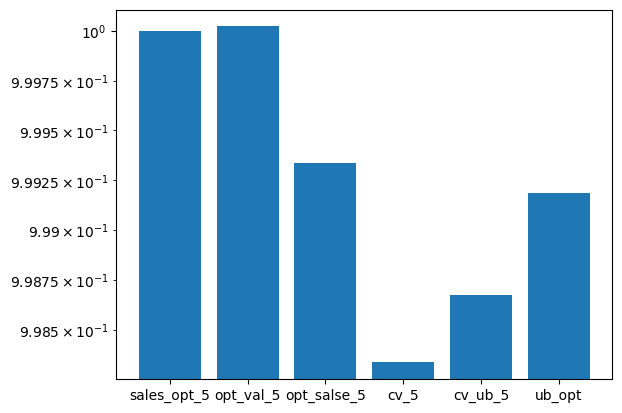

In [20]:
# ubを表示
plt.bar(
    ["sales_opt_5", "opt_val_5", "opt_salse_5", "cv_5", "cv_ub_5", "ub_opt"],
    [sales_opt_5, opt_val_5, opt_salse_5, cv_5, cv_ub_5, ub_opt_5],
)
# 対数
plt.yscale("log")
plt.show()

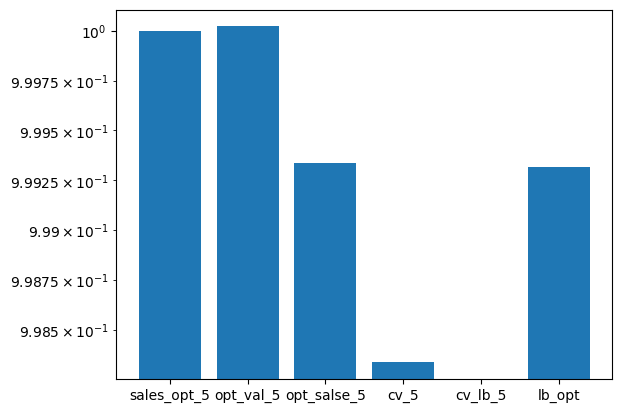

In [21]:
# lbを表示
plt.bar(
    ["sales_opt_5", "opt_val_5", "opt_salse_5", "cv_5", "cv_lb_5", "lb_opt"],
    [sales_opt_5, opt_val_5, opt_salse_5, cv_5, cv_lb_5, lb_opt_5],
)

# 対数
plt.yscale("log")
plt.show()

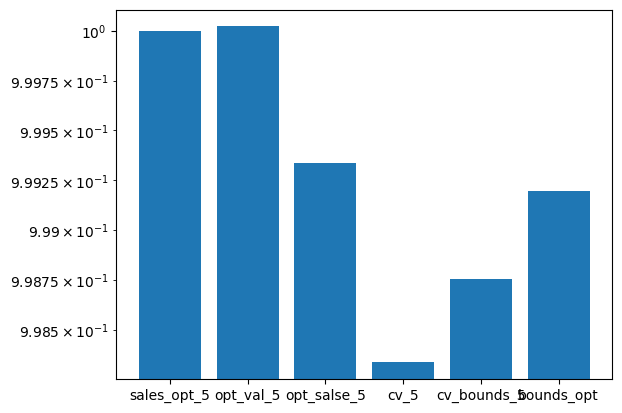

In [22]:
# boundsを表示
plt.bar(
    ["sales_opt_5", "opt_val_5", "opt_salse_5", "cv_5", "cv_bounds_5", "bounds_opt"],
    [sales_opt_5, opt_val_5, opt_salse_5, cv_5, cv_bounds_5, bounds_opt_5],
)

# 対数
plt.yscale("log")
plt.show()

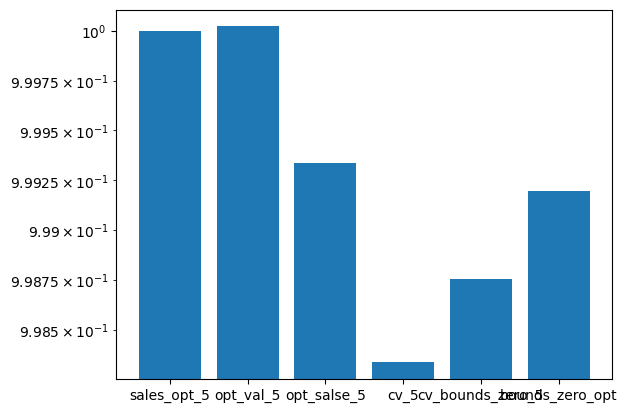

In [23]:
# bounds_zeroを表示
plt.bar(
    ["sales_opt_5", "opt_val_5", "opt_salse_5", "cv_5", "cv_bounds_zero_5", "bounds_zero_opt"],
    [sales_opt_5, opt_val_5, opt_salse_5, cv_5, cv_bounds_zero_5, bounds_zero_opt_5],
)

# 対数
plt.yscale("log")
plt.show()

In [24]:
# M = 10で100回実行
M = 10
N = 500
K = 5


opt_val_list = []

opt_sales_list = []

salse_opt_list = []

cv_list = []

cv_lb_list = []

cv_ub_list = []

cv_bounds_list = []

ub_opt_list = []

lb_opt_list = []

bounds_opt_list = []

bounds_zero_opt_list = []

initial_price = np.full(M, 0.6)

lb, ub, bounds = create_bounds(M)

for _ in range(100):
    alpha, beta, X, Y = create_date(M, N)
    opt_val_10, opt_prices_10 = predict_optimize(M, X, Y, [(0.6, 1.0) for _ in range(M)])
    opt_salse_10 = sum(sales_function(opt_prices_10, alpha, beta))
    sales_opt_10, sales_opt_price_10 = sales_optimize(M, alpha, beta)
    salse_opt_10 = -sales_opt_10
    cv_10 = cross_validation(X, Y, M, K)
    cv_ub_10, cv_ub_bounds = esitimate_ub_nelder(ub, M, X, Y, K)
    ub_opt_val, ub_opt_prices = predict_optimize(M, X, Y, cv_ub_bounds)
    ub_opt_salse = sum(sales_function(ub_opt_prices, alpha, beta))

    cv_lb_10, cv_lb_bounds = esitimate_lb_nelder(lb, M, X, Y, K)
    lb_opt_val, lb_opt_prices = predict_optimize(M, X, Y, cv_lb_bounds)
    lb_opt_salse = sum(sales_function(lb_opt_prices, alpha, beta))

    cv_bounds_10, cv_bounds = estimate_bounds_inf_nelder(bounds, M, X, Y, K)
    bounds_opt_val, bounds_opt_prices = predict_optimize(M, X, Y, cv_bounds)
    bounds_opt_salse = sum(sales_function(bounds_opt_prices, alpha, beta))

    cv_bounds_zero_10, cv_bounds_zero = estimate_bounds_zero_nelder(bounds, M, X, Y, K)
    bounds_zero_opt_val, bounds_zero_opt_prices = predict_optimize(M, X, Y, cv_bounds_zero)
    bounds_zero_opt_salse = sum(sales_function(bounds_zero_opt_prices, alpha, beta))
    opt_val_list.append(opt_val_10 / sales_opt_10)
    opt_sales_list.append(opt_salse_10 / sales_opt_10)
    salse_opt_list.append(sales_opt_10 / sales_opt_10)
    cv_list.append(cv_10 / sales_opt_10)
    cv_ub_list.append(cv_ub_10 / sales_opt_10)
    ub_opt_list.append(ub_opt_salse / sales_opt_10)
    lb_opt_list.append(lb_opt_salse / sales_opt_10)
    cv_bounds_list.append(cv_bounds_10 / sales_opt_10)

    bounds_opt_list.append(bounds_opt_salse / sales_opt_10)
    cv_bounds_zero_list.append(cv_bounds_zero_10 / sales_opt_10)
    bounds_zero_opt_list.append(bounds_zero_opt_salse / sales_opt_10)

opt_val_10 = np.mean(opt_val_list)
opt_salse_10 = np.mean(opt_sales_list)
sales_opt_10 = np.mean(salse_opt_list)
cv_10 = np.mean(cv_list)
cv_ub_10 = np.mean(cv_ub_list)
ub_opt_10 = np.mean(ub_opt_list)
cv_lb_10 = np.mean(cv_lb_list)
lb_opt_10 = np.mean(lb_opt_list)
cv_bounds_10 = np.mean(cv_bounds_list)
bounds_opt_10 = np.mean(bounds_opt_list)
cv_bounds_zero_10 = np.mean(cv_bounds_zero_list)
bounds_zero_opt_10 = np.mean(bounds_zero_opt_list)

c:\python_space\experiment2\.venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\python_space\experiment2\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


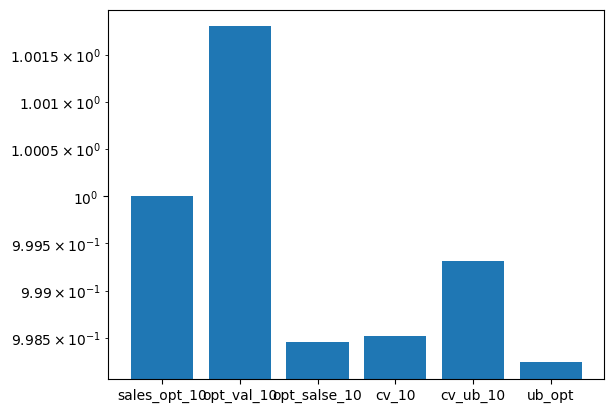

In [25]:
# ubを表示
plt.bar(
    ["sales_opt_10", "opt_val_10", "opt_salse_10", "cv_10", "cv_ub_10", "ub_opt"],
    [sales_opt_10, opt_val_10, opt_salse_10, cv_10, cv_ub_10, ub_opt_10],
)
# 対数
plt.yscale("log")
plt.show()

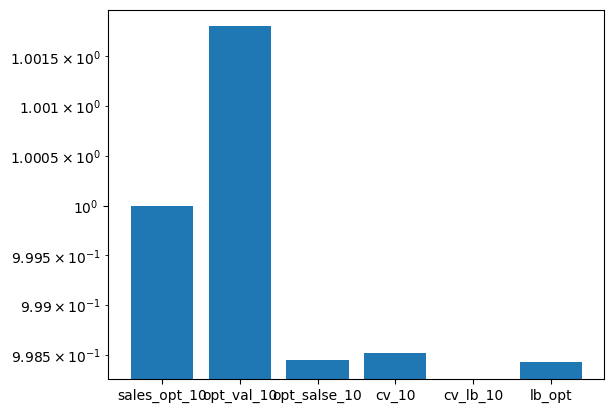

In [26]:
# lbを表示
plt.bar(
    ["sales_opt_10", "opt_val_10", "opt_salse_10", "cv_10", "cv_lb_10", "lb_opt"],
    [sales_opt_10, opt_val_10, opt_salse_10, cv_10, cv_lb_10, lb_opt_10],
)

# 対数
plt.yscale("log")
plt.show()

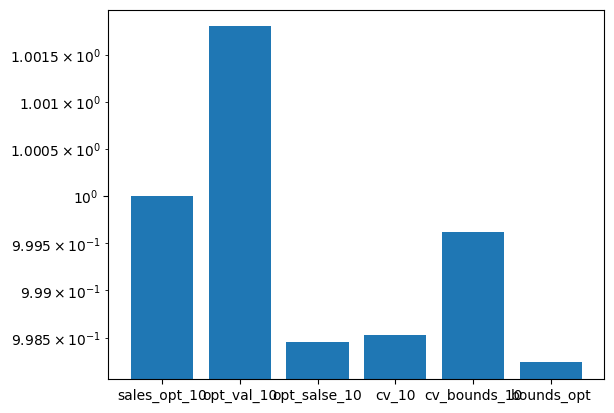

In [27]:
# boundsを表示
plt.bar(
    ["sales_opt_10", "opt_val_10", "opt_salse_10", "cv_10", "cv_bounds_10", "bounds_opt"],
    [sales_opt_10, opt_val_10, opt_salse_10, cv_10, cv_bounds_10, bounds_opt_10],
)

# 対数
plt.yscale("log")
plt.show()

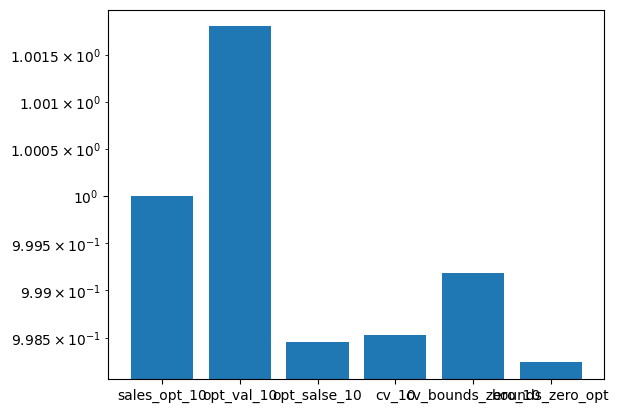

In [28]:
# bounds_zeroを表示
plt.bar(
    [
        "sales_opt_10",
        "opt_val_10",
        "opt_salse_10",
        "cv_10",
        "cv_bounds_zero_10",
        "bounds_zero_opt",
    ],
    [sales_opt_10, opt_val_10, opt_salse_10, cv_10, cv_bounds_zero_10, bounds_zero_opt_10],
)

# 対数
plt.yscale("log")
plt.show()

In [29]:
# M = 20で100回実行
M = 20
N = 500
K = 5


opt_val_list = []

opt_sales_list = []

salse_opt_list = []

cv_list = []

cv_lb_list = []

cv_ub_list = []

cv_bounds_list = []

ub_opt_list = []

lb_opt_list = []

bounds_opt_list = []

bounds_zero_opt_list = []

initial_price = np.full(M, 0.6)

lb, ub, bounds = create_bounds(M)

for _ in range(100):
    alpha, beta, X, Y = create_date(M, N)
    opt_val_20, opt_prices_20 = predict_optimize(M, X, Y, [(0.6, 1.0) for _ in range(M)])
    opt_salse_20 = sum(sales_function(opt_prices_20, alpha, beta))
    sales_opt_20, sales_opt_price_20 = sales_optimize(M, alpha, beta)
    salse_opt_20 = -sales_opt_20
    cv_20 = cross_validation(X, Y, M, K)
    cv_ub_20, cv_ub_bounds = esitimate_ub_nelder(ub, M, X, Y, K)
    ub_opt_val, ub_opt_prices = predict_optimize(M, X, Y, cv_ub_bounds)
    ub_opt_salse = sum(sales_function(ub_opt_prices, alpha, beta))

    cv_lb_20, cv_lb_bounds = esitimate_lb_nelder(lb, M, X, Y, K)
    lb_opt_val, lb_opt_prices = predict_optimize(M, X, Y, cv_lb_bounds)
    lb_opt_salse = sum(sales_function(lb_opt_prices, alpha, beta))

    cv_bounds_20, cv_bounds = estimate_bounds_inf_nelder(bounds, M, X, Y, K)
    bounds_opt_val, bounds_opt_prices = predict_optimize(M, X, Y, cv_bounds)
    bounds_opt_salse = sum(sales_function(bounds_opt_prices, alpha, beta))

    cv_bounds_zero_20, cv_bounds_zero = estimate_bounds_zero_nelder(bounds, M, X, Y, K)
    bounds_zero_opt_val, bounds_zero_opt_prices = predict_optimize(M, X, Y, cv_bounds_zero)
    bounds_zero_opt_salse = sum(sales_function(bounds_zero_opt_prices, alpha, beta))
    opt_val_list.append(opt_val_20 / sales_opt_20)
    opt_sales_list.append(opt_salse_20 / sales_opt_20)
    salse_opt_list.append(sales_opt_20 / sales_opt_20)
    cv_list.append(cv_20 / sales_opt_20)
    cv_ub_list.append(cv_ub_20 / sales_opt_20)
    ub_opt_list.append(ub_opt_salse / sales_opt_20)
    lb_opt_list.append(lb_opt_salse / sales_opt_20)
    cv_bounds_list.append(cv_bounds_20 / sales_opt_20)

    bounds_opt_list.append(bounds_opt_salse / sales_opt_20)
    cv_bounds_zero_list.append(cv_bounds_zero_20 / sales_opt_20)
    bounds_zero_opt_list.append(bounds_zero_opt_salse / sales_opt_20)

opt_val_20 = np.mean(opt_val_list)
opt_salse_20 = np.mean(opt_sales_list)
sales_opt_20 = np.mean(salse_opt_list)
cv_20 = np.mean(cv_list)
cv_ub_20 = np.mean(cv_ub_list)
ub_opt_20 = np.mean(ub_opt_list)
cv_lb_20 = np.mean(cv_lb_list)
lb_opt_20 = np.mean(lb_opt_list)
cv_bounds_20 = np.mean(cv_bounds_list)
bounds_opt_20 = np.mean(bounds_opt_list)
cv_bounds_zero_20 = np.mean(cv_bounds_zero_list)
bounds_zero_opt_20 = np.mean(bounds_zero_opt_list)

KeyboardInterrupt: 

In [ ]:
# ubを表示
plt.bar(
    ["sales_opt_20", "opt_val_20", "opt_salse_20", "cv_20", "cv_ub_20", "ub_opt"],
    [sales_opt_20, opt_val_20, opt_salse_20, cv_20, cv_ub_20, ub_opt_20],
)

# 対数
plt.yscale("log")
plt.show()

In [ ]:
# lbを表示
plt.bar(
    ["sales_opt_20", "opt_val_20", "opt_salse_20", "cv_20", "cv_lb_20", "lb_opt"],
    [sales_opt_20, opt_val_20, opt_salse_20, cv_20, cv_lb_20, lb_opt_20],
)

# 対数
plt.yscale("log")
plt.show()

In [ ]:
# boundsを表示
plt.bar(
    ["sales_opt_20", "opt_val_20", "opt_salse_20", "cv_20", "cv_bounds_20", "bounds_opt"],
    [sales_opt_20, opt_val_20, opt_salse_20, cv_20, cv_bounds_20, bounds_opt_20],
)

# 対数
plt.yscale("log")
plt.show()

In [ ]:
# bounds_zeroを表示

plt.bar(
    [
        "sales_opt_20",
        "opt_val_20",
        "opt_salse_20",
        "cv_20",
        "cv_bounds_zero_20",
        "bounds_zero_opt",
    ],
    [sales_opt_20, opt_val_20, opt_salse_20, cv_20, cv_bounds_zero_20, bounds_zero_opt_20],
)

# 対数
plt.yscale("log")
plt.show()